<a href="https://colab.research.google.com/github/guevelel/COMP4449_Plume_Analysis/blob/main/P7_Plume_COMP4449.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP4449 Final - Term Project 7: Mystery at the Wildlife Preserve (Plume Analysis)
## Edward Guevel


####Goals

1- Characterize the sensors’ performance and operation. Are they all working properly at all times? Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture?

2- Now turn your attention to the chemicals themselves. Which chemicals are being detected by the sensor group? What patterns of chemical releases do you see, as being reported in the data?

3- Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.

In [2]:
#Import Dash:
!pip3 install dash --upgrade
!pip install jupyter-dash --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.3 MB/s eta 0:00:00


In [3]:
#Import required libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

import plotly.express as px
import plotly.io as pio
from dash import Dash
from dash import dcc, html
from dash import Input, Output
from jupyter_dash import JupyterDash
pio.renderers.default = "notebook_connected"

from scipy import stats
from statistics import mean, median

from google.colab import files
import io

In [6]:
#Upload files from computer:

uploaded = files.upload()

Saving MeteorologicalData.csv to MeteorologicalData.csv
Saving SensorData.csv to SensorData.csv


In [23]:
#Write files to pandas DF:
meteor = pd.read_csv('MeteorologicalData.csv')
#meteor = pd.read_csv(io.BytesIO(uploaded['MeteorologicalData.xlsx']))
sensor = pd.read_csv('SensorData.csv')

In [24]:
meteor.head()
#meteor.describe()

,Date,Wind Direction,Wind Speed (m/s),Unnamed: 3,Unnamed: 4
0,4/1/16 0:00,190.5,4.0,NaN,NaN
1,4/1/16 3:00,203.3,5.0,NaN,NaN
2,4/1/16 6:00,201.1,5.2,NaN,NaN
3,4/1/16 9:00,204.9,4.1,NaN,NaN
4,4/1/16 12:00,207.0,3.6,NaN,NaN


In [25]:
sensor.head()
#sensor

,Chemical,Monitor,Date Time,Reading
0,Methylosmolene,3,4/1/16 0:00,2.683820
1,Methylosmolene,7,4/1/16 0:00,2.630640
2,Chlorodinine,3,4/1/16 0:00,1.259170
3,Chlorodinine,7,4/1/16 0:00,0.943983
4,AGOC-3A,3,4/1/16 0:00,0.722303


### Data Cleaning:

In [26]:
#Drop the "unnamed" columns from the meteorological data:
meteor.drop(columns=['Unnamed: 3', 'Unnamed: 4'], inplace=True)

#Rename the sensor date column:
sensor.rename(columns = {'Date Time ': 'date'}, inplace=True)

#meteor.head()
#sensor.head()#

In [27]:
#Create list of sensor coordinates:
sensor_coords = {1:[62,21],2:[66,35],3:[76,41],
                 4:[88,45],5:[103,43], 6:[102,22],
                 7:[89,3],8:[74,7],9:[119,42]}

#Append sensor_coords to sensor dataframe:
def add_x_coords(row):
  return sensor_coords[row['Monitor']][0]
def add_y_coords(row):
  return sensor_coords[row['Monitor']][1]
  
sensor['x'] = sensor.apply(lambda row: add_x_coords(row), axis=1)
sensor['y'] = sensor.apply(lambda row: add_y_coords(row), axis=1)

sensor.head()

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,4/1/16 0:00,2.683820,76,41
1,Methylosmolene,7,4/1/16 0:00,2.630640,89,3
2,Chlorodinine,3,4/1/16 0:00,1.259170,76,41
3,Chlorodinine,7,4/1/16 0:00,0.943983,89,3
4,AGOC-3A,3,4/1/16 0:00,0.722303,76,41


In [28]:
#Check for missing values:
#sensor.isnull().sum()
meteor.isnull().sum()

#Drop null values from Meteorological Data, since so few values:
meteor.dropna(axis=0, inplace=True)
meteor.isnull().sum()


Date                0
Wind Direction      0
Wind Speed (m/s)    0
dtype: int64

In [29]:
#Convert string dates to date-time objects:
sensor['date'] = pd.to_datetime(sensor['date'], format="%m/%d/%y %H:%M")

meteor['Date'] = pd.to_datetime(meteor['Date'] , format="%m/%d/%y %H:%M")

sensor.head()

,Chemical,Monitor,date,Reading,x,y
0,Methylosmolene,3,2016-04-01,2.683820,76,41
1,Methylosmolene,7,2016-04-01,2.630640,89,3
2,Chlorodinine,3,2016-04-01,1.259170,76,41
3,Chlorodinine,7,2016-04-01,0.943983,89,3
4,AGOC-3A,3,2016-04-01,0.722303,76,41


### Goal 1 - Sensor Performance and Operation

Characterize the sensors’ performance and operation. Are they all working properly at all times? Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture?

Start by comparing the two data sets in cronological order to see if they both overlap.

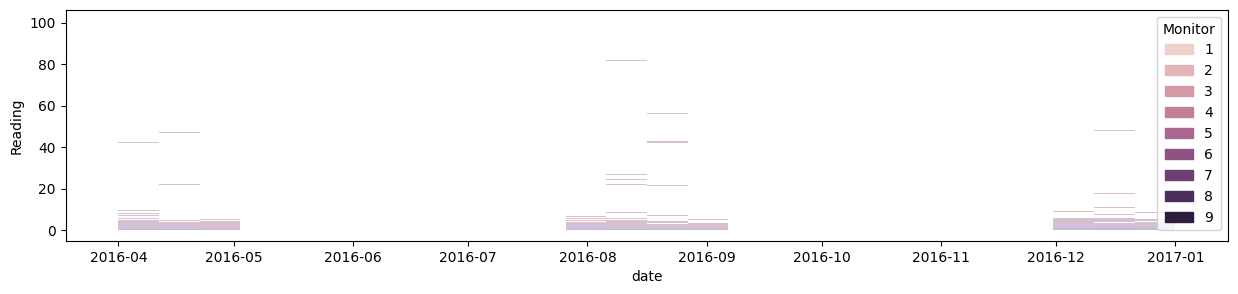

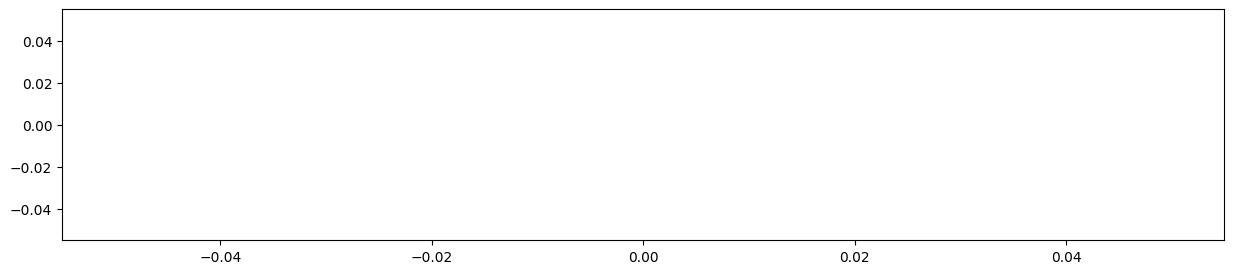

In [15]:
#Histogram of the sensor data:
plt.figure(figsize=(15,3))
sns.histplot(sensor, y=sensor['Reading'], x=sensor['date'], hue=sensor['Monitor'])
plt.show()

#Histogram of the Meteorological data:
plt.figure(figsize=(15,3))
sns.histplot(meteor, y=meteor['Wind Direction'], x=meteor['Date'], bins=100)
plt.show()

All of the wind data and sensor data are shown in the stacked plots above. We can see that the sensor data and the wind data that was pulled does not exactly overlap chronologically. However, some of the sensor data in the month of August does not have any associated wind values. We will choose to ignore these sensor values, since wind direction is a major factor when determining which companies are releasing which chemicals.

We will combine the Meteorlogical data with the sensor data to have one uniform dataset.

In [30]:
#Add wind direction and speed as columns to sensor data:

meteor_dates = meteor['Date'].tolist()

#Function to add wind values based on overlapping dates:
def add_wind(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Direction'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Direction'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Direction'].tolist()[0]

#Function to add wind values based on overlapping dates:
def add_windspeed(row):
  if row['date'] in meteor_dates:
    return meteor.loc[meteor['Date'] == row['date']]['Wind Speed (m/s)'].tolist()[0]
  else:
    if row['date'] - timedelta(hours=1) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=1))]['Wind Speed (m/s)'].tolist()[0]
    if row['date'] - timedelta(hours=2) in meteor_dates:
      return meteor.loc[meteor['Date'] == (row['date']- timedelta(hours=2))]['Wind Speed (m/s)'].tolist()[0]
 
#Apply the functions to add wind direction and speed values to the sensor dataframe:
sensor['wind'] = sensor.apply(lambda row: add_wind(row), axis=1)
sensor['wind_speed'] = sensor.apply(lambda row: add_windspeed(row), axis=1)
sensor.sample(5)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed
15572,Appluimonia,4,2016-04-19 02:00:00,0.237211,88,45,9.8,0.4
38541,Appluimonia,5,2016-08-15 19:00:00,0.422642,103,43,319.8,2.8
38339,Methylosmolene,1,2016-08-15 13:00:00,0.060578,62,21,321.2,1.7
46414,AGOC-3A,4,2016-08-24 22:00:00,0.937134,88,45,221.6,2.3
26500,AGOC-3A,8,2016-08-01 18:00:00,1.088760,74,7,NaN,NaN


<Axes: >

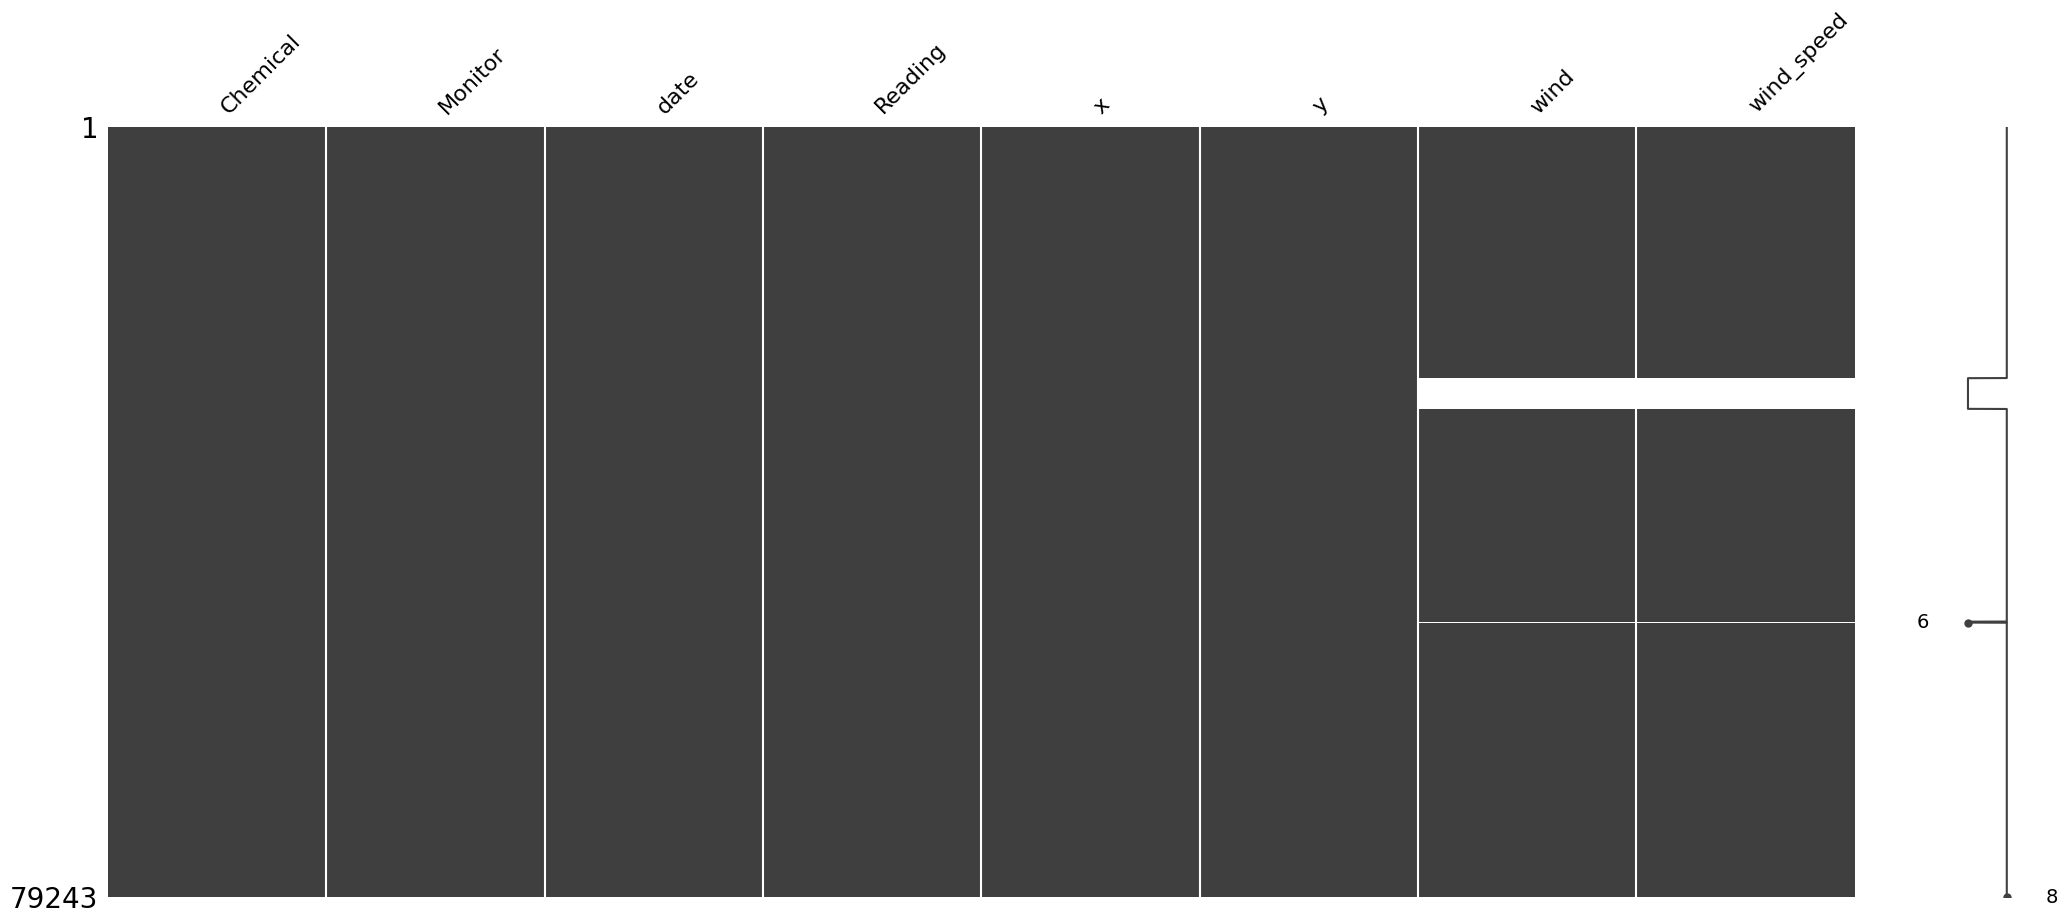

In [31]:
#Check for missing data:
import missingno as msno
msno.matrix(sensor)

Note that the Meteorological Data is missing values at the beginning of August and at the beginning of December. Overall, it is not missing very much data

In [32]:
print(f"Null values after merging data: \n {sensor.isna().sum()}")

#We will drop the null values since 3278 is only 4% of the data set:
sensor.dropna(axis=0, inplace=True)


Null values after merging data: 
 Chemical         0
Monitor          0
date             0
Reading          0
x                0
y                0
wind          3278
wind_speed    3278
dtype: int64


In [33]:
#Look at the descriptive statistics of the data:
sensor.groupby(['Monitor', 'Chemical']).agg({'Reading': [min, max, mean, median]}) #Reading


Reading                               
                             min        max      mean    median
Monitor Chemical                                               
1       AGOC-3A         0.001065   31.66583  0.247551  0.204751
        Appluimonia     0.001130    2.20189  0.234196  0.207819
        Chlorodinine    0.001015    5.09007  0.246517  0.217125
        Methylosmolene  0.001003   31.80997  0.244332  0.206787
2       AGOC-3A         0.001598   26.58683  0.379821  0.297561
        Appluimonia     0.001322    1.80374  0.358014  0.312735
        Chlorodinine    0.001633    7.46014  0.358775  0.303008
        Methylosmolene  0.001591   42.71211  0.391639  0.301542
3       AGOC-3A         0.001257   85.31459  1.604814  1.031770
        Appluimonia     0.001899    6.92741  1.262546  0.979943
        Chlorodinine    0.001661    8.96003  1.287194  1.011125
        Methylosmolene  0.002452   47.74763  1.377328  0.981951
4       AGOC-3A         0.001833   65.71898  1.506940  1.132690
        Appluimonia     0.001054    4.86055  1.136847  1.106710
        Chlorodinine    0.002067   14.58982  1.230909  1.125095
        Methylosmolene  0.001067   38.21998  1.232873  1.117135
5       AGOC-3A         0.001235   84.63599  0.927088  0.358368
        Appluimonia     0.001154    7.74279  0.462172  0.336965
        Chlorodinine    0.001040   11.74958  0.512913  0.329785
        Methylosmolene  0.001876   53.64960  0.550409  0.346014
6       AGOC-3A         0.001187   84.82578  1.329150  0.410961
        Appluimonia     0.003286    8.95095  0.419776  0.398960
        Chlorodinine    0.002921   15.04032  0.687027  0.414594
        Methylosmolene  0.001418  100.77640  0.988030  0.397912
7       AGOC-3A         0.001574   47.05521  0.698610  0.431402
        Appluimonia     0.002178    4.84236  0.603231  0.438515
        Chlorodinine    0.001124   13.40056  0.619989  0.428507
        Methylosmolene  0.001060   63.31599  0.742092  0.411834
8       AGOC-3A         0.001025  101.10558  0.568444  0.435373
        Appluimonia     0.001803    4.87418  0.475398  0.433945
        Chlorodinine    0.001076    7.44058  0.481509  0.418473
        Methylosmolene  0.001448   32.82523  0.494827  0.417768
9       AGOC-3A         0.001790   47.95602  0.715668  0.298013
        Appluimonia     0.001334    8.51651  0.428177  0.297018
        Chlorodinine    0.001216    5.03405  0.373929  0.286737
        Methylosmolene  0.001241   42.51119  0.423995  0.283902

We can see that sensors 3 and 4 have the highest mean readings, and sensors 1 and 2 have the lowest mean readings. Also, AGOC-3A and Methylosmolene have much higher max values than the other two chemicals. 

In [34]:
#Looking at all the 9 sensors combined:
sensor.groupby(['Chemical']).agg({'Reading': [min, max, mean, median, 
                                              pd.DataFrame.kurt, pd.DataFrame.skew, 
                                              pd.DataFrame.var]})

Reading                                             \
                     min        max      mean    median        kurt   
Chemical                                                              
AGOC-3A         0.001025  101.10558  0.888928  0.402039  326.142500   
Appluimonia     0.001054    8.95095  0.597818  0.393572   14.375279   
Chlorodinine    0.001015   15.04032  0.644307  0.396863   43.549728   
Methylosmolene  0.001003  100.77640  0.714902  0.386331  678.938293   

                                     
                     skew       var  
Chemical                             
AGOC-3A         15.919531  9.984065  
Appluimonia      2.901936  0.433359  
Chlorodinine     4.982767  0.718802  
Methylosmolene  23.118862  6.153433

Confirming that AGOC-3A and Methylosmolene have much higher maxes than the other chemicals, but not necessarily that much higher of a mean value. The two chemicals also hav a much higher variance and skew than Appluimonia and Chlorodinine.

In [35]:
sensor.describe()

,Monitor,Reading,x,y,wind,wind_speed
count,75965.000000,75965.000000,75965.000000,75965.000000,75965.000000,75965.000000
mean,5.000145,0.711955,86.555493,28.776437,236.451238,2.250460
std,2.581990,2.084441,17.839215,15.179378,79.239691,1.283244
min,1.000000,0.001003,62.000000,3.000000,0.100000,0.100000
25%,3.000000,0.192900,74.000000,21.000000,182.500000,1.200000
50%,5.000000,0.394688,88.000000,35.000000,251.800000,2.200000
75%,7.000000,0.748538,102.000000,42.000000,299.900000,3.100000
max,9.000000,101.105580,119.000000,45.000000,359.100000,6.800000


The wind direction is biased towards a mean of 236.45 and not 180 (true compass mean). The wind speeds are on the lower end with a mean of 2.25 out of a max of 9. The readings are overall low, with values in the 75 percentile still less than 1.

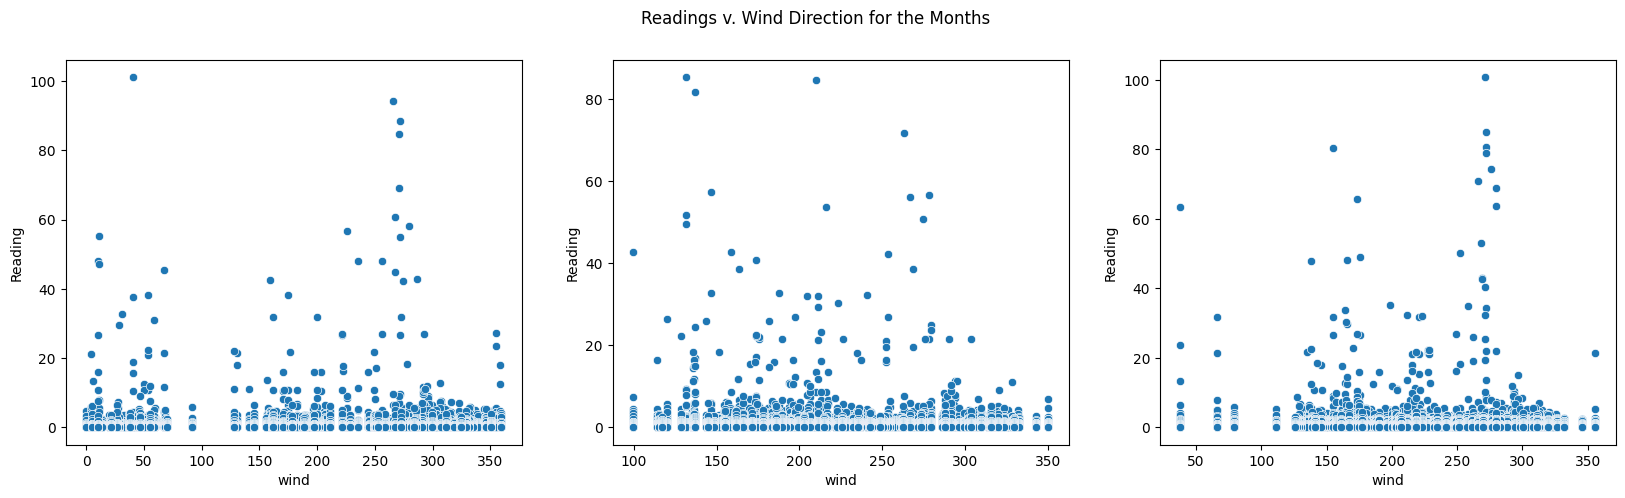

In [36]:
#Look at sensor readings for the different months:
#apr_sensor = sensor.iloc[0:25847]
#aug_sensor = sensor.iloc[25848:49248]
#dec_sensor = sensor.iloc[49249:]

months1 = [0,25848,49249]
months2 = [25847,49248,75965]

#Plots of Reading v. Methylosmolene:
plt.figure(figsize=(20,5))
for i in range(3):   
    data = sensor.iloc[months1[i]:months2[i]]
    #data = data[data['Chemical']=='Methylosmolene']
    plt.subplot(1,3,i+1)
    #plt.title(f"Sensor {monitor[i]}")
    sns.scatterplot(x=data['wind'], y=data['Reading'])
plt.suptitle('Readings v. Wind Direction for the Months')
plt.show()

Comparing the different months, we see that the sensor readings are pretty constant throught the months. There seems to be gaps in wind data (direction 75-125) for the months of April and December. However, we will choose to work with the combined dataset including all three months data instead of splitting it month to month.

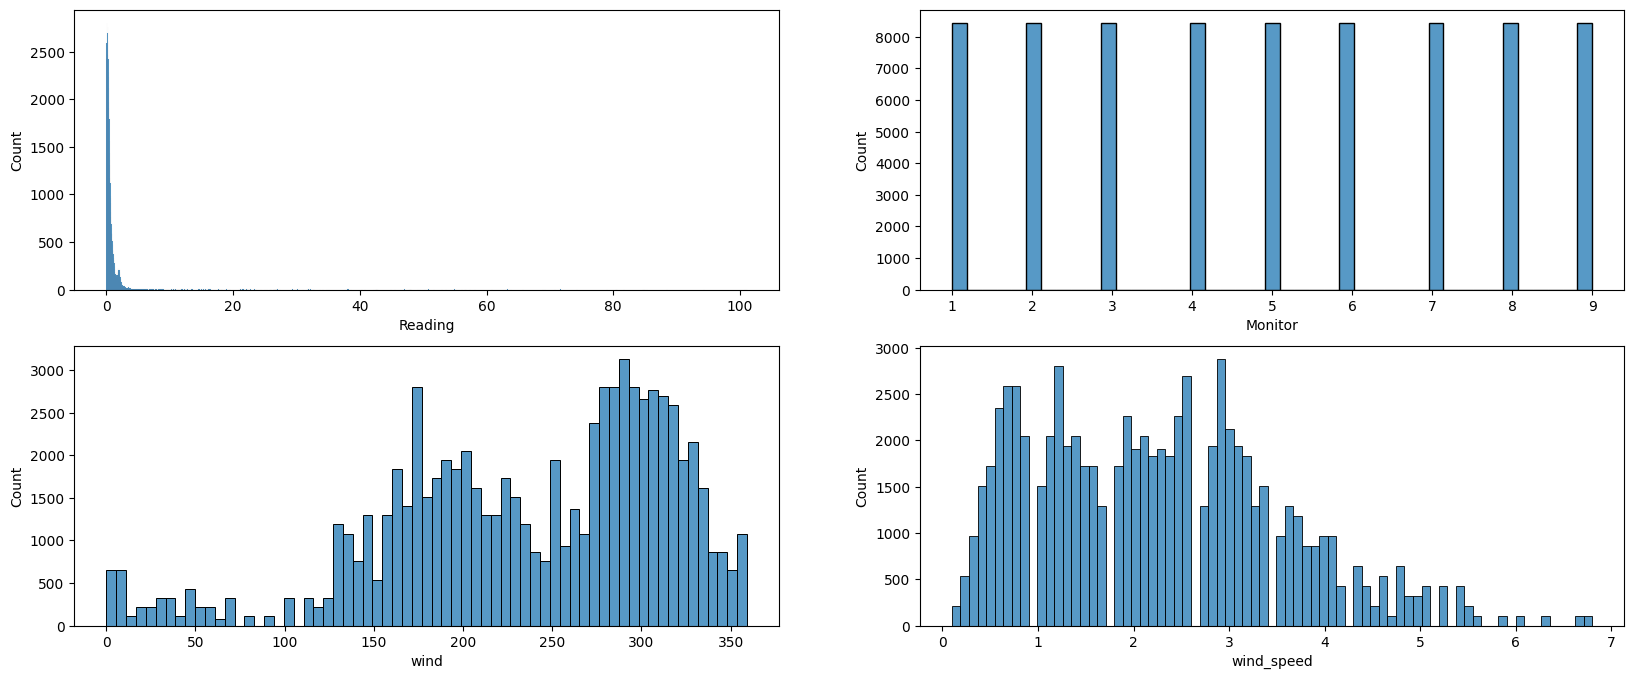

In [37]:
#Take a look at distributions for a few features:
pairs = ['Reading', 'Monitor', 'wind', 'wind_speed'] 

plt.figure(figsize=(20,8))
for i in range(4):   
    plt.subplot(2,2,i+1)
    sns.histplot(sensor[pairs[i]])
plt.show()

Looking at the distributions for the most important features above, we can see that the monitors are all reading values for the entire dataset (no null readings). The Reading value is very skewed towards 0, which confirms the data description table values from above. The winds are biased towards the higher end with the majority of the readings areound 200 and 300 directions. Finally, the wind speed distribution is biased towards the lower speeds, but is somewhat normally distributed.

In [38]:
#Add factories to sensor df for graphical purposes
sensor_graph = sensor.copy()

#Want to add all wind speeds for the factories so they show up in the plotly plots:
for i in range(0, 340, 30):
  sensor_graph = pd.concat([sensor_graph,
                      pd.DataFrame({'Chemical':'Roadrunner', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':89,'y':27, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Kasios', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':90,'y':21, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Indigo', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':120,'y':22, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
  sensor_graph  = pd.concat([sensor_graph ,
                      pd.DataFrame({'Chemical':'Radiance', 'Monitor': 20, 'date':'2016-04-01 00:00:00', 'Reading':20, 
                             'x':109,'y':26, 'wind': i, 'wind_speed':1 }, index=[0])], axis=0, ignore_index = True)
    


Let's take a look at how the sensors geographically look compared to the factories. Also, we will add a few features to the graph to help visualize what readings appear on which sensors as the wind direction changes.

In [39]:
#Create interactive graph of coordinate system with sensor, wind, and chemical data
app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=0,
            max=sensor_graph['wind'].max(),
            step=10,
            value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
    ]),
    html.Div([
            dcc.Checklist(
                ['Appluimonia', 'Chlorodinine', 'Methylosmolene', 'AGOC-3A'],
                ['Appluimonia'],
                id='chemical-type',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        html.H6('Wind Speed'),
        dcc.RangeSlider(
            id='wind_speed-slider',
            min=0,
            max=sensor_graph['wind_speed'].max(),
            step=.5,
            value=[sensor_graph['wind_speed'].min(),sensor_graph['wind_speed'].max()])
    ])
])


@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='wind_direction-slider', component_property='value'),
    Input(component_id='wind_speed-slider', component_property='value'),
    Input(component_id='chemical-type', component_property='value'))

def update_figure(selected_wind, selected_speed, selected_chemicals):
    chem = selected_chemicals
    chem = chem+['Roadrunner', 'Kasios', 'Indigo', 'Radiance']
    filtered_df = sensor_graph[(sensor_graph.wind >= selected_wind[0])&
                              (sensor_graph.wind <= selected_wind[1])&
                               (sensor_graph.wind_speed >= selected_speed[0])&
                               (sensor_graph.wind_speed <= selected_speed[1])&
                              (sensor_graph.Chemical.isin(chem)
                              )]
                               
    fig = px.scatter(filtered_df, x="x", y="y",
                 size="Reading", color="Chemical", hover_name="Chemical",
                 size_max=20, color_discrete_map={'Appluimonia': 'blue', 
                                                   'Chlorodinine': 'red', 
                                                  'Methylosmolene': 'yellow',
                                                  'AGOC-3A': 'green'})
    #color_discrete_sequence=px.colors.qualitative.Antique)
    fig.update_layout(transition_duration=100)
    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

In [40]:
#Assign all dates to a numerical value:
l = list(sensor['date'].unique())
sensor['datenum']  = sensor['date'].apply(lambda x: l.index(x) )
  
sensor.head(2)

,Chemical,Monitor,date,Reading,x,y,wind,wind_speed,datenum
0,Methylosmolene,3,2016-04-01,2.68382,76,41,190.5,4.0,0
1,Methylosmolene,7,2016-04-01,2.63064,89,3,190.5,4.0,0


Lets look at an interactive graph of the sensor readings v. the Date to see if we can spot any abnormalities in the sensor readings throught their "active" time. The graph allows us to toggle on and off the individual sensor and chemical readings while also sliding through different wind direction ranges and date ranges.

In [41]:
#Interactive plot for Reading v. Date:

app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
            dcc.Checklist(
                [1,2,3,4,5,6,7,8,9],
                [1],
                id='monitor-selection',
                inline=True
            ),
            dcc.Checklist(
                ['Appluimonia', 'Chlorodinine', 'Methylosmolene', 'AGOC-3A'],
                ['Appluimonia'],
                id='chemical-type',
                inline=True
            )
        ], style={'width': '48%', 'display': 'inline-block'}),
    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=0,
            max=sensor['wind'].max(),
            step=10,
            value=[sensor['wind'].min(),sensor['wind'].max()])
    ]),
    html.Div([
        html.H6('Date Range'),
        dcc.RangeSlider(
            id='date-slider',
            #min=0,
            min = sensor['datenum'].min(),
            #max=d[-1],
            max=sensor['datenum'].max(),
            step=10,
            #value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
            #value=[0,d[-1]])
            value=[sensor['datenum'].min(),sensor['datenum'].max()])
    ]),
])
@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'),
    Input(component_id='monitor-selection', component_property='value'),
    Input(component_id='chemical-type', component_property='value'),
    Input(component_id='wind_direction-slider', component_property='value')
)

def update_figure(selected_date, selected_monitor, selected_chemicals, selected_wind):

    filtered_df = sensor[(sensor.datenum >= selected_date[0]) & (sensor.datenum <= selected_date[1]) & 
                         (sensor.Monitor.isin(selected_monitor)) & (sensor.Chemical.isin(selected_chemicals)) &
                         (sensor_graph.wind >= selected_wind[0])& (sensor_graph.wind <= selected_wind[1])]

    fig = px.scatter(filtered_df, x="date", y="Reading", color='Chemical',
                     color_discrete_map={'Appluimonia': 'blue', 
                                         'Chlorodinine': 'red',
                                         'Methylosmolene': 'yellow',
                                         'AGOC-3A': 'green'})

    fig.update_layout(transition_duration=100)
    #fig.update_xaxes(rangeslider_visible=True)

    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

Narrowing in the date range above, when all Sensors and Chemicals are selected, allows us to pinpoint the irregularities in the sensor data. We can see that there are at least 7 time ranges where the sensors did not record data. I also added the wind directions at those times.

Blackout Dates & Times:

April 2nd: 0:00, Wind Drection: 262.3, Wind Speed: 2.9

April 6th: 0:00, Wind Drection: 307.1, Wind Speed: 2.3

April 29th: 6:00, Wind Drection: 359.1, Wind Speed: 0.4

August 7th: 0:00, Wind Drection: 287.7, Wind Speed: 0.9

August 30: 3:00, Wind Drection: unknown, Wind Speed: unknown

December 2nd: 0:00, Wind Drection: 254.2, Wind Speed: 3.0

December 7th: 0:00 (Cholorodinine and Appluimonia only), Wind Drection: 134.9, Wind Speed: 0.7


We will graph the specific blackout dates to confirm what we were able to determine in our interactive plot above.

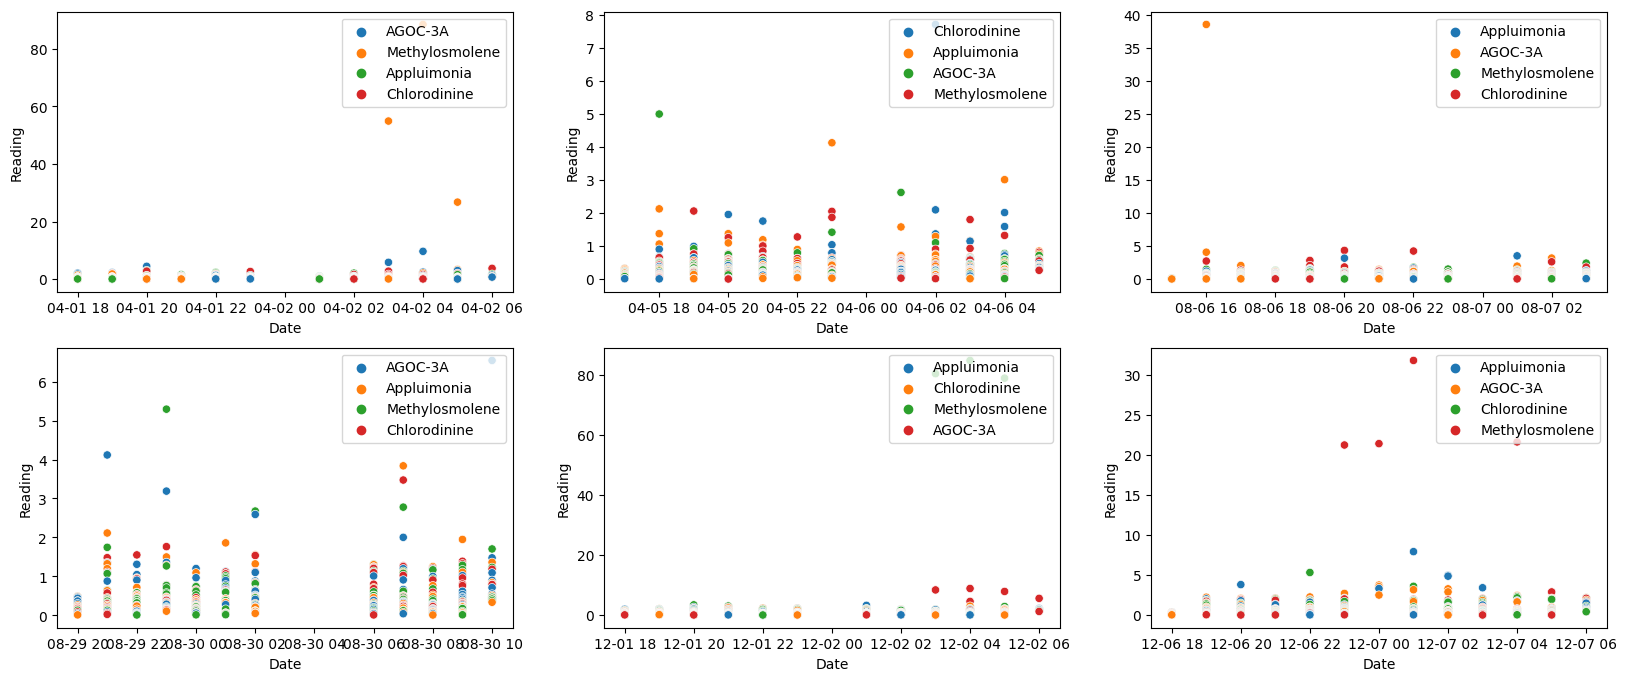

In [42]:
#Visualize all of the missing sensor data date ranges:

#Problematic dates (numerical conversions - iloc):
blackouts = [850, 4250,27700,47700, 50100, 54400] #(id 24400)

plt.figure(figsize=(20,8))
for i in range(6):   
    plt.subplot(2,3,i+1)
    sns.scatterplot(data = sensor.iloc[blackouts[i]-200:blackouts[i]+200], x='date', y='Reading',
                   hue='Chemical')
    plt.legend(loc='upper right')
    plt.xlabel('Date')
plt.show()


### Goal 2 - Chemical Patterns:
Now turn your attention to the chemicals themselves.Which chemicals are being detected by the sensor group? What patterns of chemical releases do you see, as being reported in the data?

We will create an interactive graph of sensor reading v. Wind direction to add to our graphs above. This will allow us to visualize which sensors are picking up which chemical readings at specific wind directions. The graph will also allow you to toggle specific sensors and chemicals as well as scroll through the wind speeds.

In [43]:
#Plots for Reading v. Wind:

app = JupyterDash()

app.layout = html.Div(children = [
    html.Div([
        dcc.Graph(id='graph-with-slider'),
    ]) ,
    html.Div([
            dcc.Checklist(
                [1,2,3,4,5,6,7,8,9],
                [1],
                id='monitor-selection',
                inline=True
            ),
            dcc.Checklist(
                ['Appluimonia', 'Chlorodinine', 'Methylosmolene', 'AGOC-3A'],
                ['Appluimonia'],
                id='chemical-type',
                inline=True
            ),
            #dcc.Checklist(
            #    ['AllReadings', 'Readings1'],
            #    ['AllReadings'],
            #    id='reading-type',
            #    inline=True),
        ], style={'width': '48%', 'display': 'inline-block'}),

    html.Div([
        html.H6('Wind Direction'),
        dcc.RangeSlider(
            id='wind_direction-slider',
            min=sensor['wind'].min(),
            max=sensor['wind'].max(),
            step=5,
            value=[sensor['wind'].min(),sensor['wind'].max()])
    ]),
    html.Div([
        html.H6('Wind Speed'),
        dcc.RangeSlider(
            id='wind_speed-slider',
            min=0,
            max=sensor['wind_speed'].max(),
            step=.5,
            value=[sensor['wind_speed'].min(),sensor['wind_speed'].max()])
    ]),
    html.Div([
        html.H6('Date Range'),
        dcc.RangeSlider(
            id='date-slider',
            #min=0,
            min = sensor['datenum'].min(),
            #max=d[-1],
            max=sensor['datenum'].max(),
            step=10,
            #value=[sensor_graph['wind'].min(),sensor_graph['wind'].max()])
            #value=[0,d[-1]])
            value=[sensor['datenum'].min(),sensor['datenum'].max()])
    ]),
])
@app.callback(
    Output(component_id='graph-with-slider', component_property='figure'),
    Input(component_id='date-slider', component_property='value'),
    Input(component_id='monitor-selection', component_property='value'),
    Input(component_id='chemical-type', component_property='value'),
    Input(component_id='wind_direction-slider', component_property='value'),
    Input(component_id='wind_speed-slider', component_property='value'),
    #Input(component_id='reading-type', component_property='value')
)

def update_figure(selected_date, selected_monitor, selected_chemicals, selected_wind, selected_speed):#, selected_reading):

    filtered_df = sensor[(sensor.datenum >= selected_date[0]) & (sensor.datenum <= selected_date[1]) & 
                         (sensor.Monitor.isin(selected_monitor)) & (sensor.Chemical.isin(selected_chemicals)) &
                         (sensor.wind >= selected_wind[0])& (sensor.wind <= selected_wind[1])&
                         (sensor.wind_speed >= selected_speed[0])& (sensor.wind_speed <= selected_speed[1])]
    
    #if selected_reading == 'Readings1':
    #    filtered_df = filtered_df[filtered_df['Reading']>=1]
    #else:
    #    filtered_df = filtered_df
        

    fig = px.scatter(filtered_df, x="wind", y="Reading", color='Chemical', 
                     hover_data=['Reading', 'Chemical', 'wind_speed','date'],
                     color_discrete_map={'Appluimonia': 'blue', 
                                         'Chlorodinine': 'red',
                                         'Methylosmolene': 'yellow',
                                         'AGOC-3A': 'green'})

    fig.update_layout(transition_duration=100)
    #fig.update_xaxes(rangeslider_visible=True)

    return fig

app.run_server(mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>

Now looking at the Wind Direction v. Reading Graph above, we can start to look at specific wind directions that draw a line between various sensors and factories. 

I used the interactive plot of Wind Direction v. Reading graph above to explore the data and understand the chemical readings across all of the sensors for various wind directions. Below, I have isolated each chemical and recreated some of the anomolies I saw in the interactive plot above. This data will be extremely helpful when drawing conclusions about the responsible factories.  

**Chlorodinine**

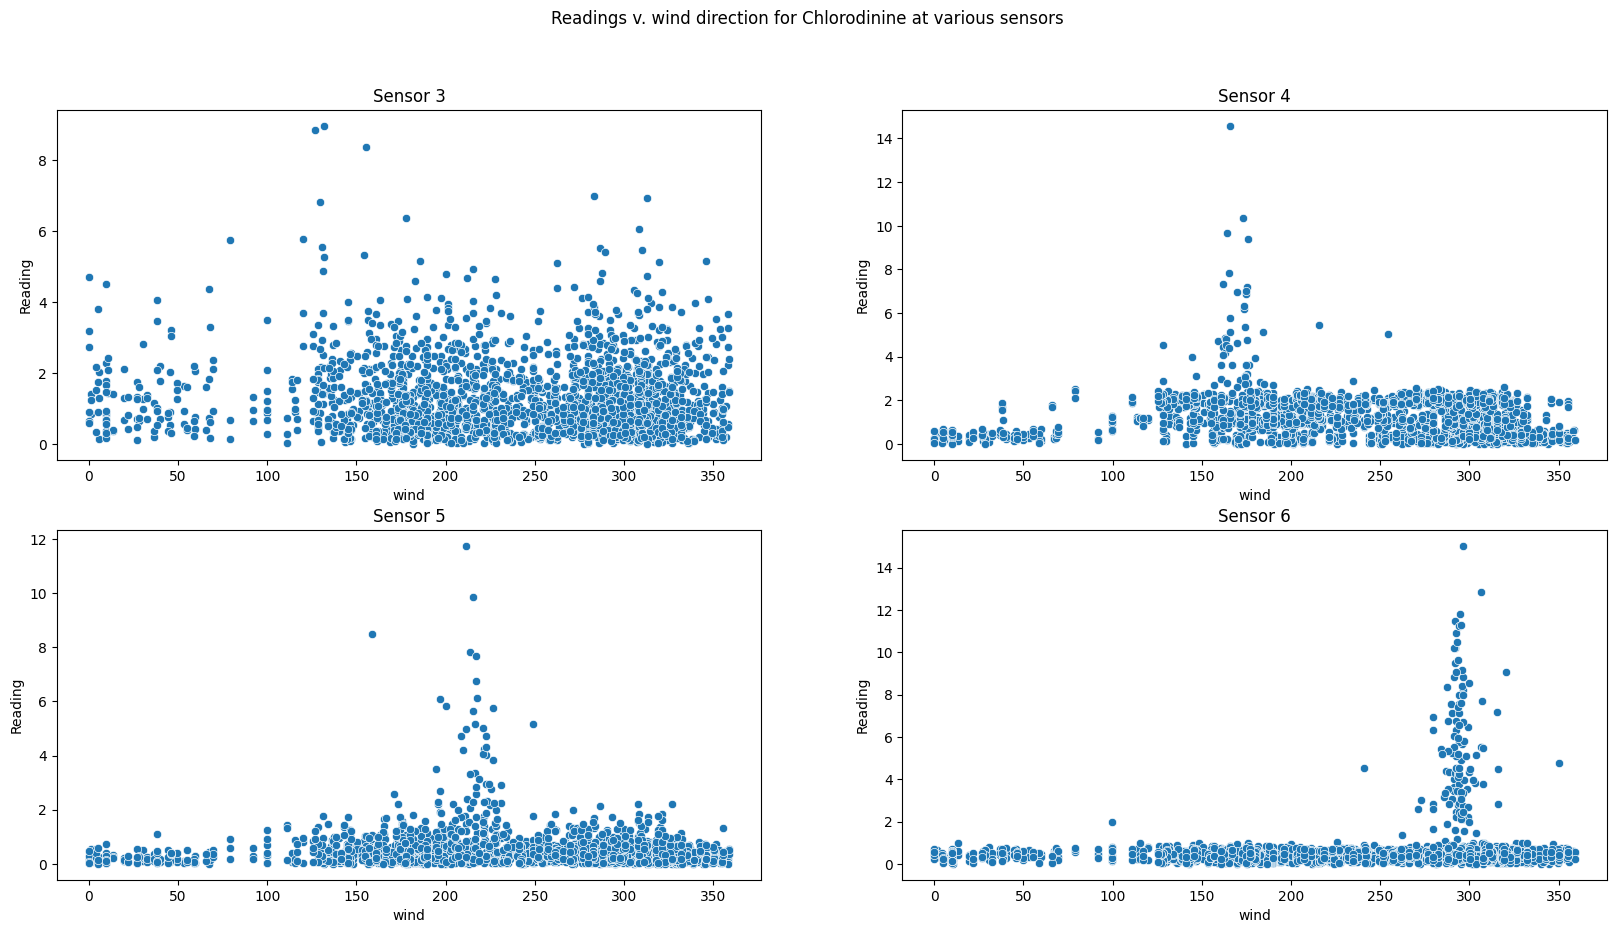

In [44]:
#Select specific monitors to look at:
monitor = [3,4,5,6]

#Plots of Reading v. Chlorodinine:
plt.figure(figsize=(20,10))
for i in range(4):   
    data = sensor[sensor['Monitor']==monitor[i]]
    data = data[data['Chemical']=='Chlorodinine']
    plt.subplot(2,2,i+1)
    plt.title(f"Sensor {monitor[i]}")
    sns.scatterplot(x=data['wind'], y=data['Reading'])
plt.suptitle('Readings v. wind direction for Chlorodinine at various sensors')
plt.show()

Sensor 3: Shows a high average reading of Chlorodinine overall. Sensor 3 is closest in proximity to the Roadrunner and Kasios factories.

Sensor 4: Shows a high spike in Chlorodinine readings when the wind is blowing in the 170 direction. Sensor 4 happens to be inline with both Roadrunner and Kasios factories when the wind is 170. 

Sensor 5: Shows a high spike in Chlorodinine readings when the wind is blowing in the 225 direction. Sensor 5 happends to be inline with the Roadrunner factory when the wind is 225. 

Sensor 6: Shows a high spike in Chlorodinine readings when the wind is blowing in the 300 direction. Sensor 6 happends to be inline with the Roadrunner factory when the wind is 300. 

**Appluimonia**

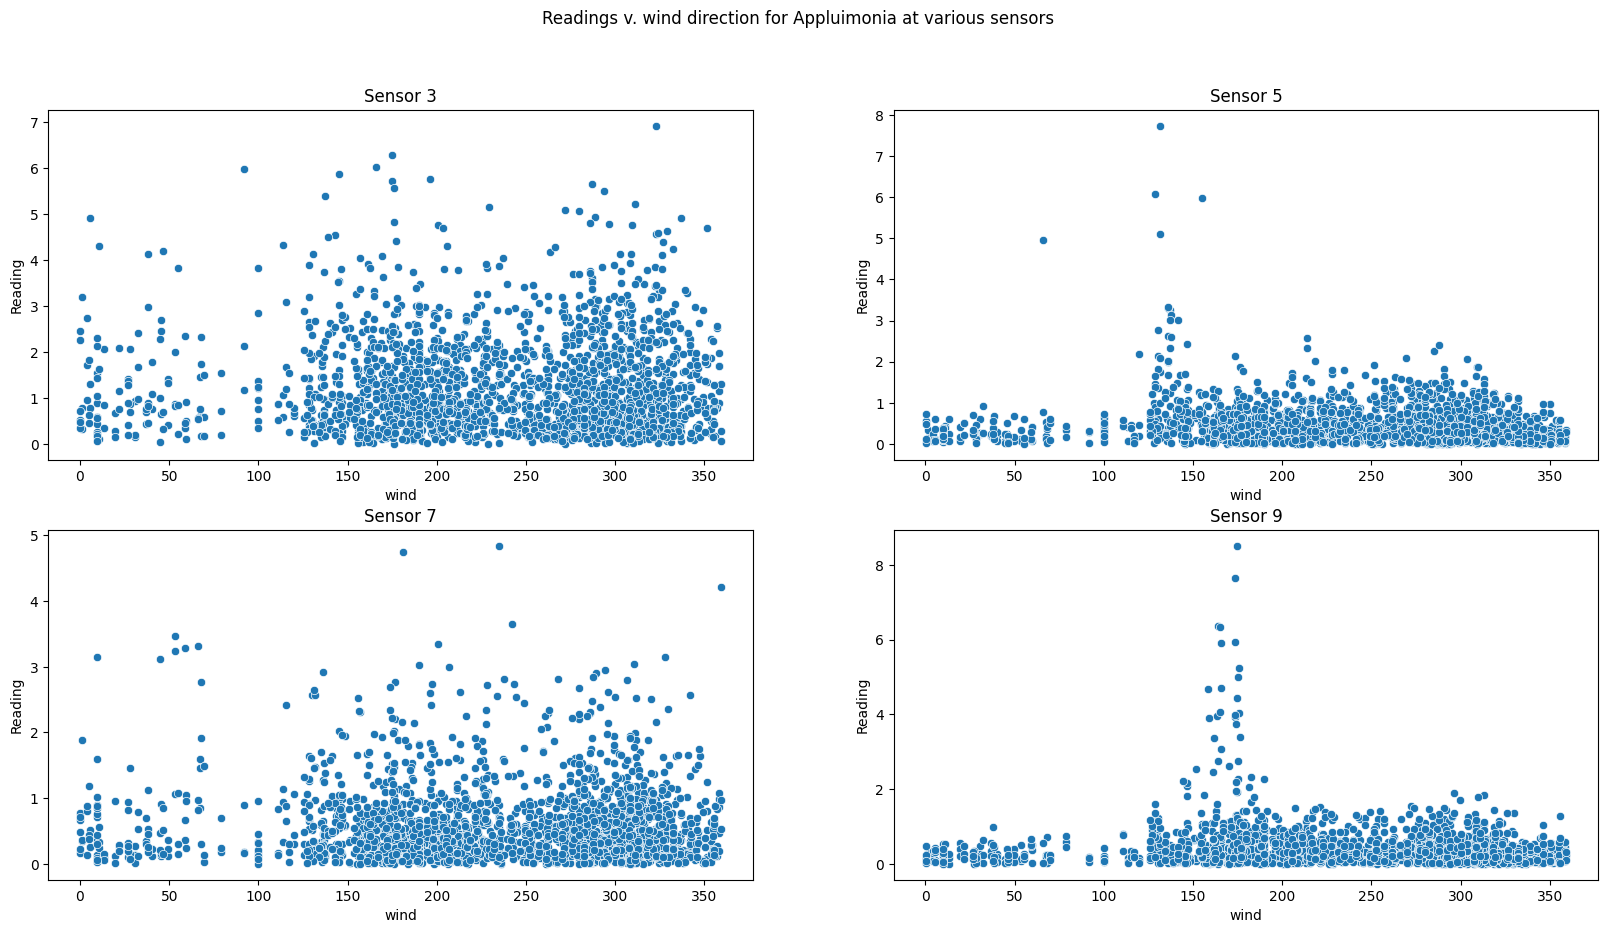

In [45]:
#Select specific monitors to look at:
monitor = [3,5,7,9]

#Plots of Reading v. Appluimonia:
plt.figure(figsize=(20,10))
for i in range(4):   
    data = sensor[sensor['Monitor']==monitor[i]]
    data = data[data['Chemical']=='Appluimonia']
    plt.subplot(2,2,i+1)
    plt.title(f"Sensor {monitor[i]}")
    sns.scatterplot(x=data['wind'], y=data['Reading'])
plt.suptitle('Readings v. wind direction for Appluimonia at various sensors')
plt.show()

Sensor 3: Shows high average readings of Appluimonia throught the wind directions. Sensor 3 is closest to Roadrunner and Kasios factories.

Sensor 5: Shows a spike in readings of Appluimonia when the wind is in the 130 direction. Sensor 5 is directly in line with the Indigo (and possibly Radiance) factory when the wind is 130.

Sensor 7: Shows high average readings of Appluimonia throught the wind directions. Sensor 7 is closest to both the Roadrunner and Kasios factories.

Sensor 9: Shows a spike in readings of Appluimonia when the wind is in the 170 direction. Sensor 9 is directly in line with the Indigo factory when whe wind is 170.

**Methylosmolene**

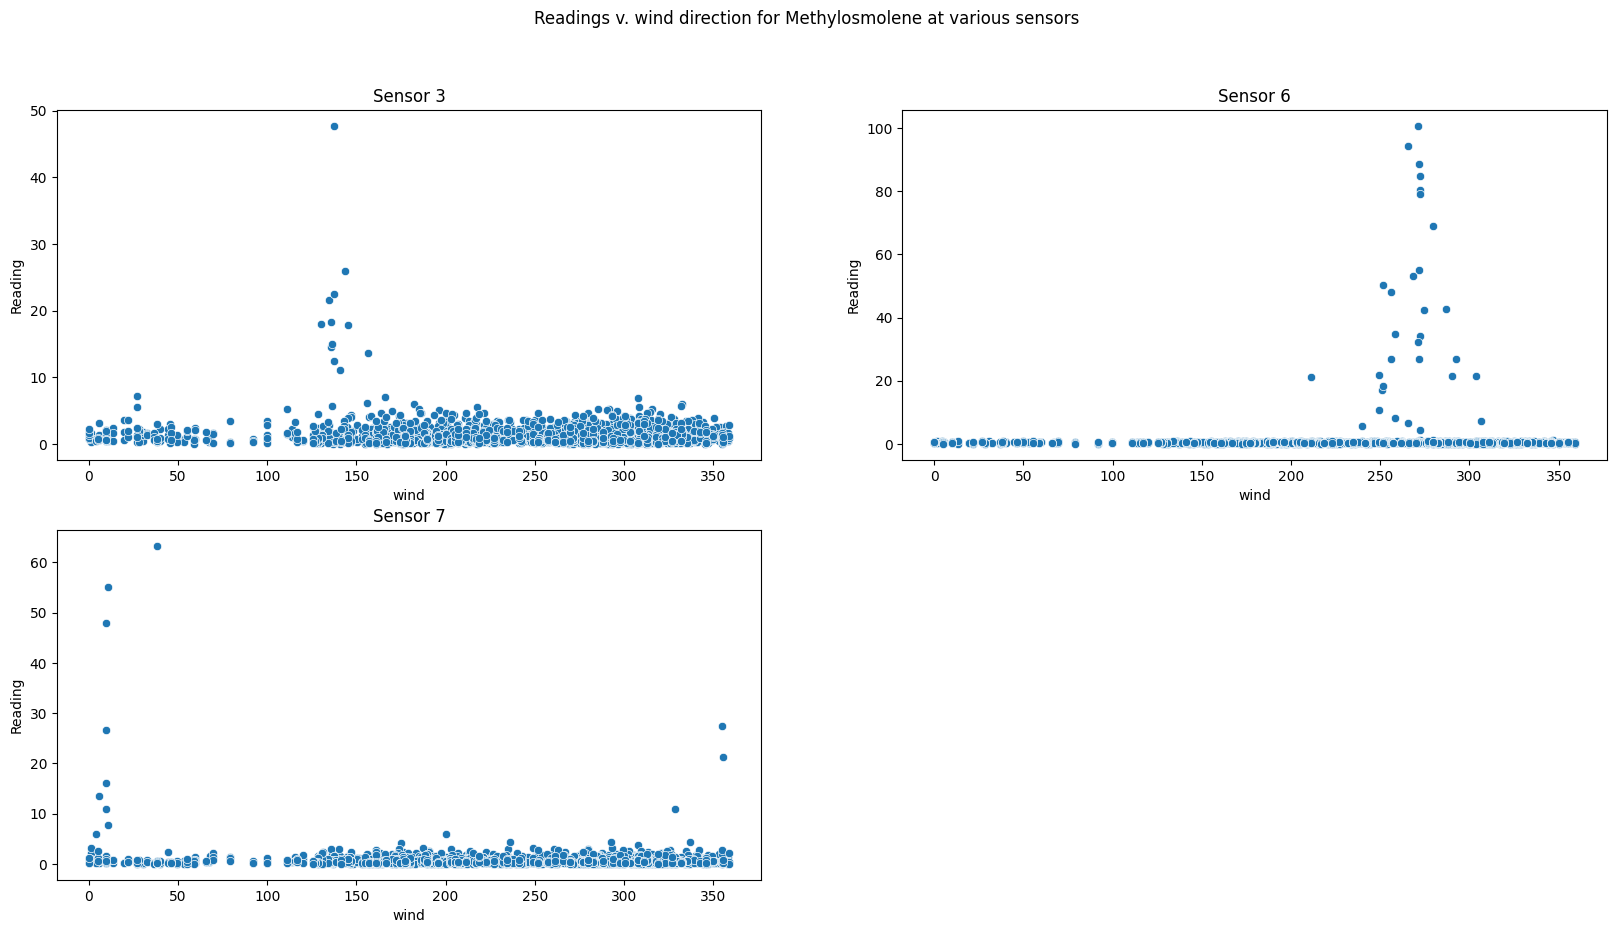

In [46]:
#Select specific monitors to look at:
monitor = [3,6,7]

#Plots of Reading v. Methylosmolene:
plt.figure(figsize=(20,10))
for i in range(3):   
    data = sensor[sensor['Monitor']==monitor[i]]
    data = data[data['Chemical']=='Methylosmolene']
    plt.subplot(2,2,i+1)
    plt.title(f"Sensor {monitor[i]}")
    sns.scatterplot(x=data['wind'], y=data['Reading'])
plt.suptitle('Readings v. wind direction for Methylosmolene at various sensors')
plt.show()

Sensor 3: Shows a spike in readings when the wind is around 135 direction. Sensor 3 is fairly in line with the Roadrunner and Kasios factories when the wind is 135.

Sensor 6: Shows a spike in readings when the wind is in the 250 through 300 direction. Sensor 6 is inline with both the Roadrunner and Kasios factories when the wind is 250-300.

Sensor 7: Shows a spike in readings when the wind is in the 10 direction. Sensor 7 is closest to the Kasios factory and is inline with the Kasios factory when the wind is 10.

**AGOC-3A**

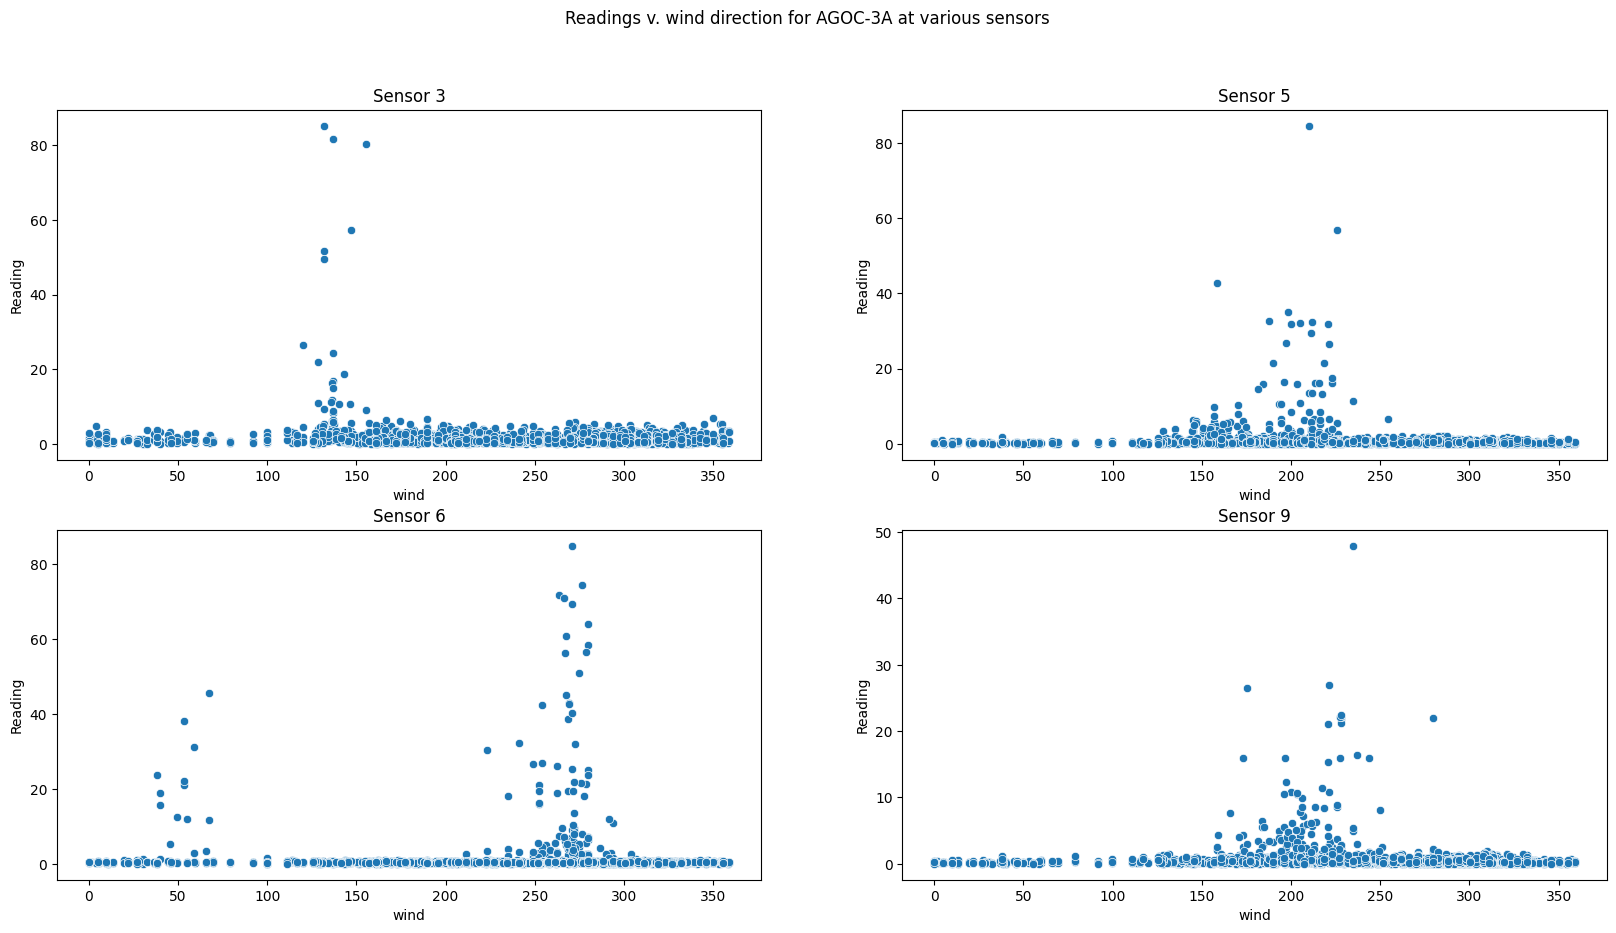

In [47]:
#Select specific monitors to look at:
monitor = [3,5,6,9]

#Plots of Reading v. AGOC-3A:
plt.figure(figsize=(20,10))
for i in range(4):   
    data = sensor[sensor['Monitor']==monitor[i]]
    data = data[data['Chemical']=='AGOC-3A']
    plt.subplot(2,2,i+1)
    plt.title(f"Sensor {monitor[i]}")
    sns.scatterplot(x=data['wind'], y=data['Reading'])
plt.suptitle('Readings v. wind direction for AGOC-3A at various sensors')
plt.show()

Sensor 3: Shows a spike in readings in AGOC-3A when the wind is in the 135 direction. Sensor 3 is directly in line with the Roadrunner and Kasios factories when the wind is 135.

Sensor 5: Shows a spike in readings in AGOC-3A when the wind is in the 225 direction. Sensor 5 is directly in line with the Roadrunner and Kasios factories when the wind is 225. Also, shows a smaller spike in AGOC-3A readings at wind is around 160, which is in line with the Radiance factory.

Sensor 6: Shows a spike in readings in AGOC-3A when the wind is in the 300 direction. Sensor 6 is in line with the Roadrunner and Kasios factories when the wind is 300. Also, showing a smaller spike in AGOC-3A readings at wind is around 50, which is in line with the Indigo factory.

Sensor 9: Shows a spike in readings in AGOC-3A when the wind is in the 170 through 230 direction. Sensor 9 is in the direction of the Indigo and Radiance factories when the wind is blowing in this range.

### Goal 3 - Responsible Factories:
Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.

Let us combine all of the data from goals 1 and 2 above to draw conclusions for each of the factories. We have analyzed the sensors for suspicious behavior (blackout dates) and looked at which chemicals they pick up based on the wind conditions. The data analysis above has given us the tools to determine which factories are responsible for dumping which chemicals.

**Indigo Sol Boards:**-make specialized snowboards (used to be wood and fiberglass skateboards) 

Indigo Sol Boards is definitly responsible for releasing Appluimonia. The sensor 9 readings show us the strongest evidence. Sensor 9 picks up a major spike in Appluimonia readings when the wind direction is 180, and that is directly upwind of Indigo Sol Boards with no other factories anywhere near that direction. There is also a blackout date on December 7th, when the wind direction is 134.7. Looking at Sensor 5 readings, we can see that there is a spike in Appluimonia when the wind is directly in line with Indigo (direction 135).





 **Radiance ColourTek:**
-make metalic flake paints 

Radiance ColourTek could be releasing Appluimonia, but there is not strong or clear evidence that it is. We would need more sensor data to confirm or deny. Sensor 6 shows the strongest signs of Appluimonia coming from Radiance (wind direction 70), but there is not much wind data for the lower values. Sensor 5 shows a spike in Appluimonia coming from Radiance (wind direction 150), but that direcition is also in line with Indigo Sol Boards that is definitly releasing Appluimonia.

Radiance ColourTek is probably releasing AGOC-3A, and there is some evidence to support this. Sensor 6 shows higher readings of AGOC-3A when the wind is inline with Radiance (wind direction 155) and there appears to be missing wind data at direction 150. Sensor 9 shows a spike in AGOC-3A when the wind is inline with Radiance (direction 225), but there is missing data when the wind is 220.

**Kasios Office Furniture:**-make metal and composite wood office furnature 

Kasios Office Furniture is definitely releasing AGOC-3A. Sensor 6 probably gives us the best signs of this, since we can most easily isolate it from Roadrunner Fitness Electronics. Sensor 6 shows high spikes of AGOC-3A when the wind is at 275, which is directly in line with Kasios. There is also a blackout date on April 2nd when the wind is 262.3, which is likely Kasios tampering with the sensors. Sensor 5 also shows a strong spike in AGOC-3A when the wind is inline with Kasios (wind=225), and a large gap in data when the wind is 220.

Kasios Office Furniture is also releasing Methylosmolene. Sensor 6 gives us clear signs of the Methylosmolene dumping. When the wind direction is at 270, right in the direction of Kasios, we see extremely high spikes of Methylosmolene. Also, at this same wind direciton, there was a blackout date on December second, whcih could mean Kasios is tampering with the sensors before they dump Methylosmolene.
Sensor3(NW)= spike in AGOC-3A and subtle spike in Methylosmolene 

**Roadrunner Fitness Electronics:** -make fitness consumer electronics 

Roadrunner Fitness Electronics is definitely releaseing Chlorodinine. Sensor 6 probably gives us the best signs of this, since we can most easily isolate it from Kasios Office Furniture. Sensor 6 shows high spikes of Chlorodinine when the wind direction is at 290, which is directly in line with Roadrunner. Also, there are two blackout dates, August 7th (wind=287.7) and April 6th (wind=307.1), which tells us that Roadrunner was trying to tamper with the sensors when dumping Chlorodinine. Sensors 4 and 5 also show significant spikes in Chlorodinine when the wind direction is in line with Roadrunner.